# Reset the coordinate origin to the location of PMJ
PMJ is close to the coordinate orginin of NMTv2.0asym. This will help to initialize registration with reasonable overlaps.
We will change the origin of the following images:
1. The 16 single-subject macaque images from PRIME-DE
2. Their corresponding brain masks

## Imports

In [2]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
from nilearn import plotting

## Set paths

In [3]:
# Path to AFNI executables
AFNI_BIN = '/usr/local/AFNI' 

# Path to template files (MODIFY if needed)
template_dir = "/home/nsirmpilatze/home@dpz/afids/templates"
# NMTv2.0asym template (only brain, without surrounding tissue)
template = os.path.join(template_dir, "NMT_v2.0_asym_SS.nii.gz")

# Paths to 16 single-subject T1w images from PRIME-DE (MODIFY if needed)
subjects_dir = "/home/nsirmpilatze/home@dpz/afids/single-subjects"
# List of paths to individual images
subject_imgs = [
    os.path.join(subjects_dir, img)
    for img in os.listdir(subjects_dir)
    if img.endswith("T1w.nii.gz")
]
subject_imgs.sort()
# List of subject IDs
subjects = [os.path.basename(img).split("_")[0] for img in subject_imgs]
print(f"Subjects: {subjects}")

# Paths to brain masks (from PRIME-DE U-NET model 136 masks release)
# https://github.com/HumanBrainED/NHP-BrainExtraction
masks_dir = os.path.join(subjects_dir, 'brainmasks')
prefixes = [os.path.basename(img).split("_T1")[0] for img in subject_imgs]
masks = [os.path.join(masks_dir, f'{p}_brainmask.nii.gz') for p in prefixes]

# Path to folder with fiducial placements (Fid32)
fid32_dir = os.path.join(subjects_dir, "Fid32")

# Set output directories for images and masks with modified origin
out_dir_imgs = os.path.join(subjects_dir, "T1w_origin-PMJ")
out_dir_masks = os.path.join(subjects_dir, "brainmasks_origin-PMJ")

Subjects: ['sub-032104', 'sub-032105', 'sub-032107', 'sub-032108', 'sub-032198', 'sub-032199', 'sub-032201', 'sub-032203', 'sub-032209', 'sub-032210', 'sub-032211', 'sub-032212', 'sub-032213', 'sub-032214', 'sub-032215', 'sub-032216']


## Compute and visualize mean PMJ location (across raters) for each image
For visualization we use `nilearn`, which treats the coordinates the same as `Slicer` - **RAS**

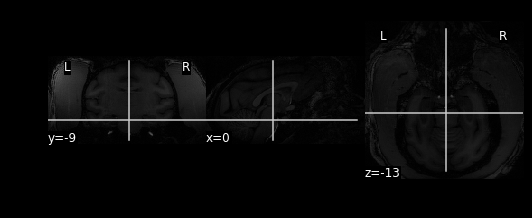

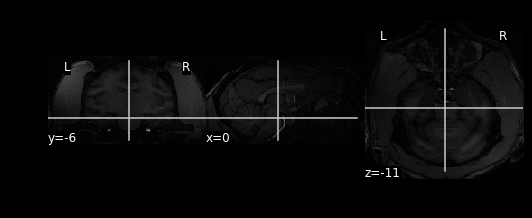

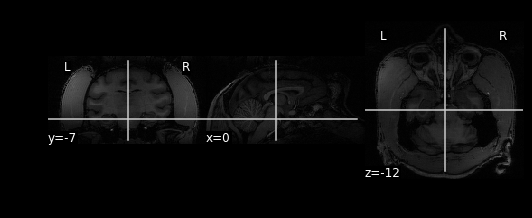

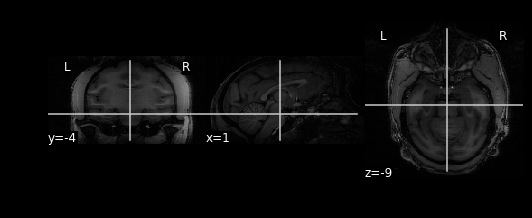

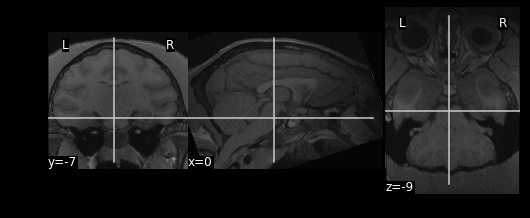

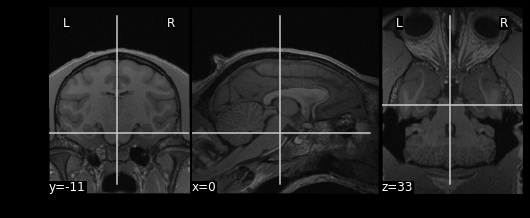

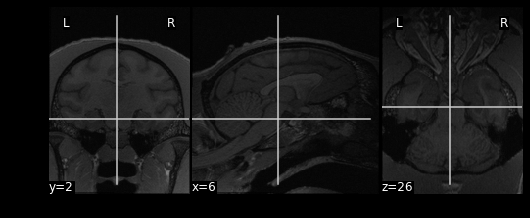

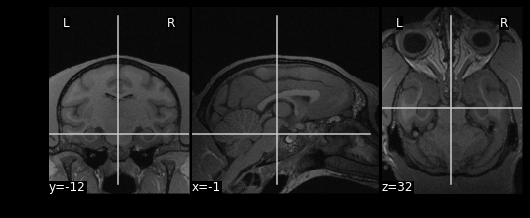

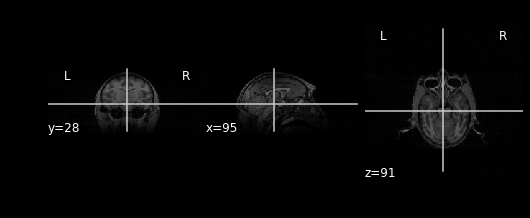

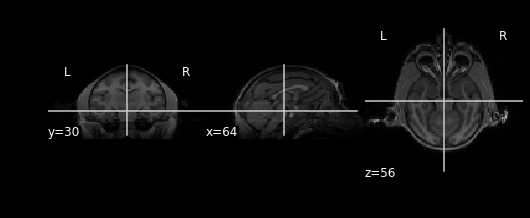

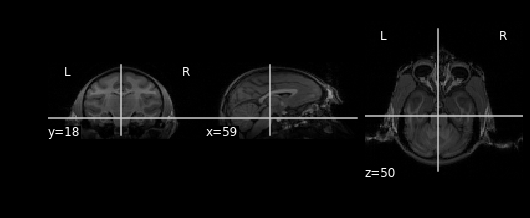

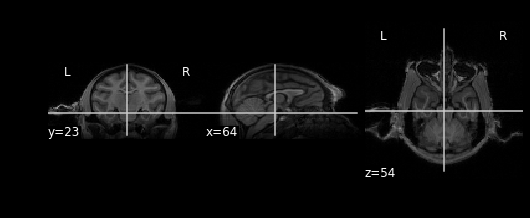

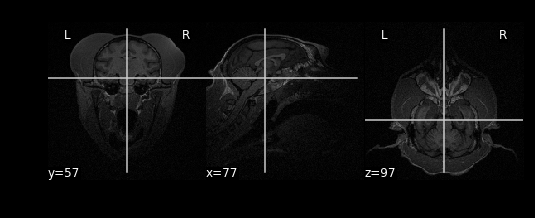

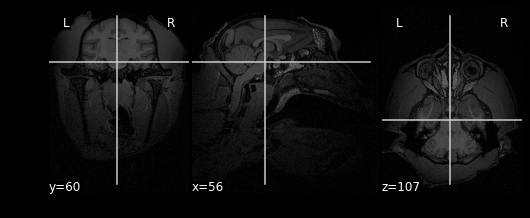

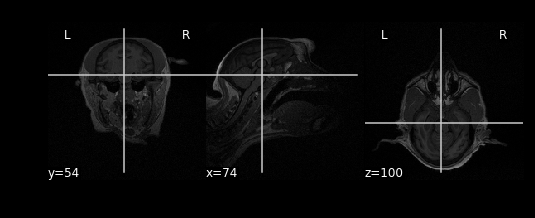

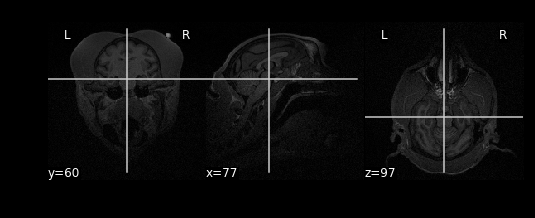

In [10]:
# Number of images (single-subject T1s)
N_imgs = len(subject_imgs) 
# Empty array to hold mean PMJ coords per image
imgs_PMJ = np.empty((N_imgs, 3)) 

for i, img in enumerate(subject_imgs):
    subject = subjects[i]
    # List of Fid32 placement sets for a given image
    fids = [f for f in os.listdir(fid32_dir) if subject in f] 
    N_sets = len(fids) 
    # Empty array to hold mean PMJ coords per placement
    PMJ = np.empty((N_sets, 3)) 

    for j, fid in enumerate(fids):
        # Read Fid32 table
        df = pd.read_csv(os.path.join(fid32_dir, fid), skiprows=2, names=None)
        # Extract x, y, z coords for PMJ
        PMJ[j, :] = df.iloc[3, 1:4].values
    # Compute mean PMJ coords
    imgs_PMJ[i, :] = np.mean(PMJ, axis=0)

    # Plot mean PMJ coordinate
    orig_x, orig_y, orig_z = imgs_PMJ[i, :]
    plotting.plot_anat(img, cut_coords=[orig_x, orig_y, orig_z])

# save mean PMJ coordinates
np.savetxt(os.path.join(out_dir_imgs, 'PMJ_coords_mean.txt'), imgs_PMJ, fmt='%.6f')

## Set coordinate origin to the mean location of PMJ
This is done for both T1w images and their brain masks.
All images are first copied (to avoid modifying the originals).

A **important note** on coordinate systems:

Both `Slicer` (which we used to define the fiducials) and `nilearn` (which we use here for visualization) treat the coordinates according to the **RAS** convention, meaning:

* x-axis: left-to-right
* y-axis: posterior-to-anterior
* z-axis: inferior-to-superior

For resetting the coordinate origin, we will use a command from `AFNI`, which by default follows another convention, which it calls **RAI**-dicom. **CAUTION**: `AFNI` follows a different naming logic for the axes, so **RAI**-dicom here means the following:

* x-axis: right-to-left
* y-axis: anterior-to-posterior
* z-axis: inferior-to-superior

This means that to "translate" our PMJ coordinates from `Slicer` **RAS** to `AFNI` **RAI** (equivalent to **LPS** per `Slicer's` naming convention) we need to flip the first 2 coordinates (along axis x and y).

In [12]:
subject_imgs_copy = []
subject_masks_copy = []
for i, img in enumerate(subject_imgs):
    
    subject = subjects[i]
    prefix = prefixes[i]
    img_copy = os.path.join(out_dir_imgs, f"{prefix}_T1w_origin-PMJ.nii.gz")
    shutil.copy(img, img_copy)
    subject_imgs_copy.append(img_copy)
    print(f"T1w image copied for {subject}")
    
    mask_copy = os.path.join(out_dir_masks, f"{prefix}_brainmask_origin-PMJ.nii.gz")
    shutil.copy(masks[i], mask_copy)
    subject_masks_copy.append(mask_copy)
    print(f"Brain mask copied for {subject}")
    
    # PMJ coordinates in Slicer/nilearn RAS:
    orig_x, orig_y, orig_z = imgs_PMJ[i, :] 
    # Same coordinates expressed in AFNI RAI /Slicer-nilearn LPS (flip first 2 axes)
    orig_x, orig_y, orig_z = -orig_x, -orig_y, orig_z 
    
    # To set the PMJ location to [0, 0, 0], we need to subtract it from the current origin
    # This means shifting the origin along each axis by MINUS the PMJ coordinate
    cmd1 = f"{AFNI_BIN}/3drefit -quiet -dxorigin {-orig_x} -dyorigin {-orig_y} -dzorigin {-orig_z} {img_copy}"
    subprocess.run(cmd1, shell=True)
    print(f"Coordinate origin reset to PMJ for the copy of {subject} T1w image")
    
    cmd2 = f"{AFNI_BIN}/3drefit -quiet -dxorigin {-orig_x} -dyorigin {-orig_y} -dzorigin {-orig_z} {mask_copy}"
    subprocess.run(cmd2, shell=True)
    print(f"Coordinate origin reset to PMJ for the copy of  {subject} brain mask")

T1w image copied for sub-032104
Brain mask copied for sub-032104
Coordinate origin reset to PMJ for the copy of sub-032104 T1w image
Coordinate origin reset to PMJ for the copy of  sub-032104 brain mask
T1w image copied for sub-032105
Brain mask copied for sub-032105
Coordinate origin reset to PMJ for the copy of sub-032105 T1w image
Coordinate origin reset to PMJ for the copy of  sub-032105 brain mask
T1w image copied for sub-032107
Brain mask copied for sub-032107
Coordinate origin reset to PMJ for the copy of sub-032107 T1w image
Coordinate origin reset to PMJ for the copy of  sub-032107 brain mask
T1w image copied for sub-032108
Brain mask copied for sub-032108
Coordinate origin reset to PMJ for the copy of sub-032108 T1w image
Coordinate origin reset to PMJ for the copy of  sub-032108 brain mask
T1w image copied for sub-032198
Brain mask copied for sub-032198
Coordinate origin reset to PMJ for the copy of sub-032198 T1w image
Coordinate origin reset to PMJ for the copy of  sub-032

## Visualize the new coordinate origin
If the above step worked, the `[0, 0, 0]` coordinate should coincide with the PMJ. The brain mask will be shown in red.

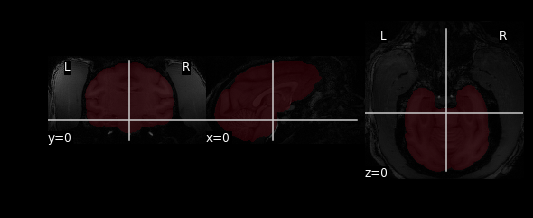

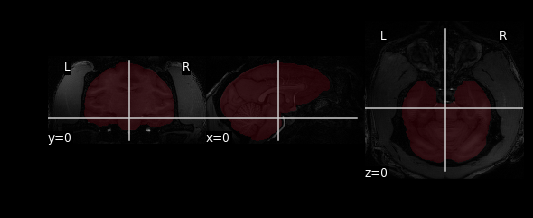

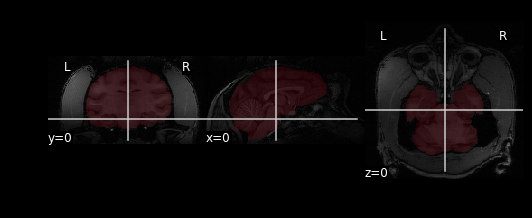

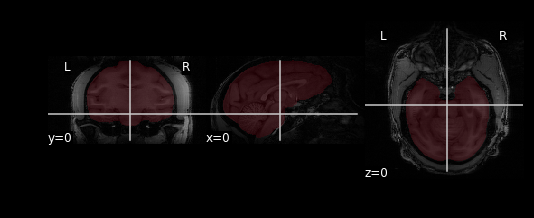

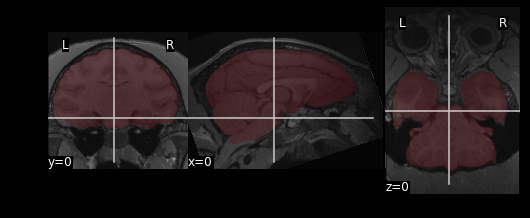

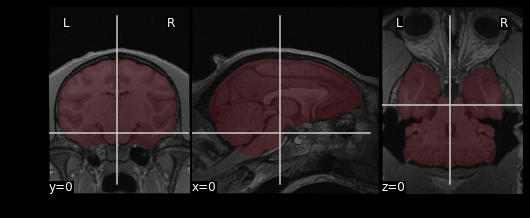

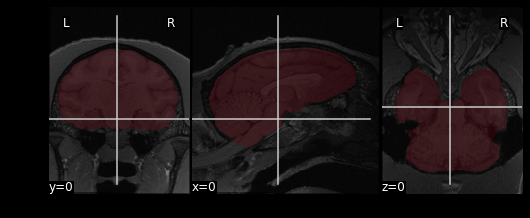

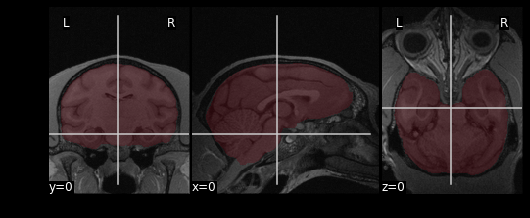

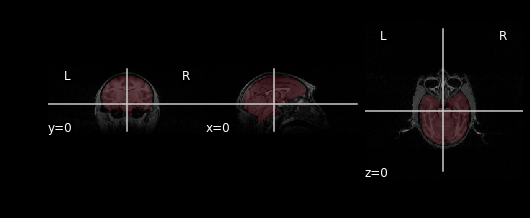

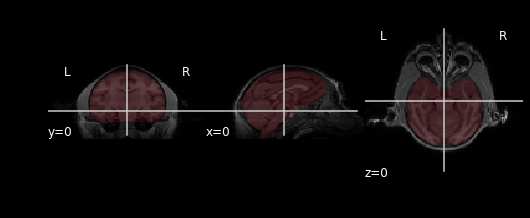

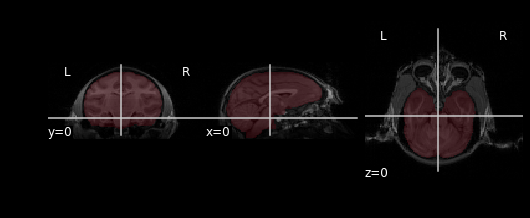

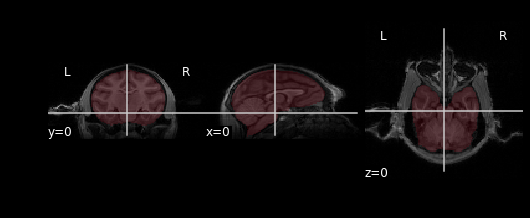

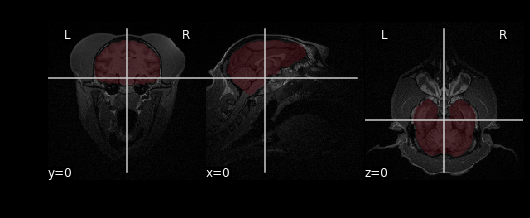

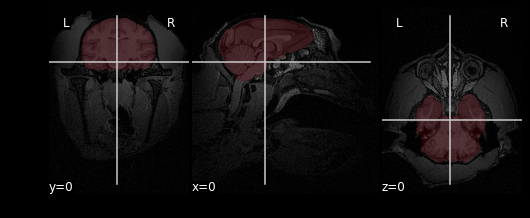

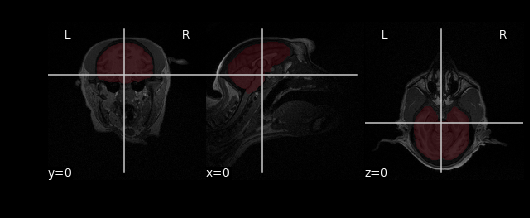

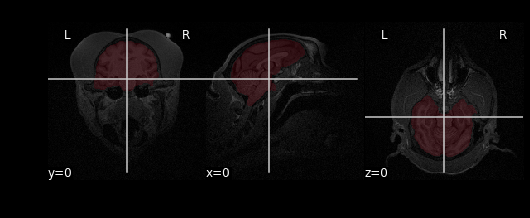

In [16]:
for i, new_img in enumerate(subject_imgs_copy):
    new_mask = subject_masks_copy[i]
    fig = plotting.plot_anat(new_img, cut_coords=[0, 0, 0])
    fig.add_overlay(new_mask, alpha=0.3, cmap='Reds_r')